# A Hitchhiker's Guide to Indian Patent Analytics

This notebook is intended to be read with the article of the same title published on LinkedIn.

This article shows how Indian Patent Office data downloaded from a free [PATENTSCOPE](http://patentscope.wipo.int) account can be used for patent analytics projects. The capabilities of such amateur efforts are obviously limited, but as the results here show, it is possible to perform moderately sophisticated search and comparison efforts. Such exercises can also be very effective as learning and training aids.

In this example we compare the [IPC codes](https://en.wikipedia.org/wiki/International_Patent_Classification) in patent applications filed by two steel-making companies in the last 5 years. The results of the analysis are presented in the form of the scatter plot shown below.

![IPC Scatter Plot](ipc-scatter-article.png)

Each colored point on this scatter plot depicts an IPC code from a patent application of one company (identified by color). Points on such [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) mapping diagrams are located so that "... *similar objects are modeled by nearby points and dissimilar objects are modeled by distant points* ..." (quoted from [Wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)). Any cluster of points all of the same color therefore could possibly be a strong group of related patents -- a matter of some concern to the other company. Such maps are useful for the identification of strong patent groups, white-spaces and [thickets](https://en.wikipedia.org/wiki/Patent_thicket) in the evaluation of competitive strengths.

The input data used for this notebook (the Excel file named *resultList2.xls*) was downloaded earlier and then cleaned using a process described in the LinkedIn article.

# Preliminaries

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Excel from  Patentscope

In [2]:
import pandas as pd

df = pd.read_excel('resultList2.xls', 'ResultSet')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
print('Data has %d rows and %d columns' % df.shape)
print('Columns: %s' % ', '.join(df.columns))

Data has 1197 rows and 11 columns
Columns: application_id, application_number, publication_number, publication_date, title, priority_data, ipc, applicants, inventors, fp_image, nat_phase_entries


### Select Last 5 Years Data

In [3]:
df5 = df[df['publication_date'].str.contains('\d{2}.\d{2}.201[4-8]')].copy()
print('Record count: %d' % len(df5))

Record count: 547


# Preliminary Data Analysis and Enrichment

### Add a *company* column

In [4]:
df5['company'] = np.where(df5['applicants'].str.contains('TATA[ -]?STEEL'), 'TATA', 'SAIL')

### Calculate and Display Relative Patent Counts

TATA    343
SAIL    204
Name: company, dtype: int64



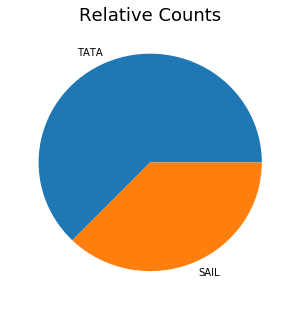

In [5]:
counts = df5['company'].value_counts()

print(counts)
print('')

ax = counts.plot.pie(figsize=(5, 5))
ax.set_title('Relative Counts', fontsize=18)
ax.set_ylabel('')
None

### Display Some Sample Data

In [6]:
df5[['publication_number', 'publication_date', 'title', 'ipc', 'company', 'inventors']].sample(5)

,publication_number,publication_date,title,ipc,company,inventors
1160,IN352/KOL/2015,20.10.2017,A COLD CHAMBER FOR AN ANNEALING SIMULATOR,G06F 17/50,SAIL,B.Ravi Kumar;S.K.Mandal;Nimai Halder;R.K.Sharm...
1146,IN1320/KOL/2013,29.05.2015,'A PROCESS FOR PRODUCTION OF LOW SULPHUR DIREC...,C22B 1/00,TATA,T VENUGOPALAN;Y RAJSHEKAR;KOTTANA NAVEEN KUMAR...
579,IN1509/KOL/2011,26.08.2016,AN IMPROVED METHOD TO PRODUCE PAVING BLOCKS FR...,E01C 5/22,TATA,MR. SANJAY KUMAR;MR. SUSHANTA KUMAR NATH;MR. T...
1150,IN1454/KOL/2013,10.07.2015,PROCESS FOR PRETREATMENT OF COAL AND MINERALS ...,B02C 19/00,TATA,VEERENDRA SINGH;PRADIP KUMAR BANERJEE;DR. G. J...
535,IN257/KOL/2015,20.10.2017,A BRIQUETTING COMPOSITION FOR USE IN BLAST FUR...,C10L 5/14,SAIL,Bhupendra Kr Dewangan;Dr.Srinivas Dwarapudi;Ch...


# *Feature Engineering* -- Convert IPC codes into Text (*Sentences*)

Convert the IPC codes into *sentences* to facilitate subsequent processing with scikit-learn's [text-feature-extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) capabilities.

### Extract IPC codes into arrays

In [8]:
ipc_regex = re.compile('[A-H]\s*[0-9]{2}\s*[A-Z]\s*(?:[0-9]+(?:/(?:[0-9]+)?)?)?')

df5['ipc_list'] = df5['ipc'].str.findall(ipc_regex)
df5 = df5[df5['ipc_list'].str.len() != 0]

print('With IPCs record count: %d' % len(df5))
ipclen = df5['ipc_list'].str.len()
print(ipclen.min(), ipclen.mean(), ipclen.max())

With IPCs record count: 543
1 1.3333333333333333 4


### IPC to Sentence Converter

In [9]:
ipcregex = re.compile('([A-H])\s*(?:(\d{2})\s*(?:([A-Z])\s*(?:(\d+)\s*(?:/\s*(\d+))?)?)?)?')

def ipc_sentence(ipc):
    parts = [part.strip('[ /]') for part in re.match(ipcregex, ipc).groups() if part]
    s = parts[0]
    if len(parts) > 1:
        s += ' ' + parts[0] + parts[1]
        if len(parts) > 2:
            s += ' ' + parts[0] + parts[1] + parts[2]
            if len(parts) > 3:
                s += ' ' + parts[0] + parts[1] + parts[2] + parts[3]
                if len(parts) > 4:
                    s += ' ' + parts[0] + parts[1] + parts[2] + parts[3] + parts[4]
    return s

def multi_ipc_sentence(ipcs):
    return ' '.join([ipc_sentence(ipc) for ipc in ipcs])

### Test IPC to Sentence Conversion

In [10]:
multi_ipc_sentence(['A 13 K 127 / 999'])

'A A13 A13K A13K127 A13K127999'

### Convert all IPC Codes

In [11]:
ipc_sentence = df5['ipc_list'].map(multi_ipc_sentence)

### Display Converted Sentence Samples

In [12]:
ipc_sentence.sample(10)

663     C C23 C23C C23C14 C23C1424 F F16 F16K F16K25 F...
618     C C23 C23C C23C2 C23C200 C C22 C22C C22C38 C22...
1158                             C C02 C02F C02F3 C02F300
334                            B B22 B22D B22D11 B22D1110
1080    G G05 G05B G05B19 G05B1900 B B23 B23Q B23Q5 B2...
1146                             C C22 C22B C22B1 C22B100
1089    F F16 F16D F16D1 F16D100 B B25 B25B B25B5 B25B500
600                            C C04 C04B C04B28 C04B2814
608     B B04 B04C B04C5 B04C500 B B04 B04C B04C3 B04C...
151                           H H01 H01L H01L31 H01L31042
Name: ipc_list, dtype: object

# Apply Text-Processing Techniques

### Generate TF-IDF Word Counts

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, stop_words='english').fit(ipc_sentence)
tf = vectorizer.transform(ipc_sentence)
print('Rows: %d, Features: %d' % tf.shape)

Rows: 543, Features: 887


# Prepare Word Counts for Scatter Plot Display

### Use TruncatedSVD to Reduce to 100 Features

In [14]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=100)
tsvd100 = tsvd.fit_transform(tf)
print('Rows: %d, Features: %d' % tsvd100.shape)

Rows: 543, Features: 100


### Use t-SNE to Obtain 2-D (X, Y) Mapping

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(tsvd100)
print('Rows: %d, Features: %d' % tsne.shape)

Rows: 543, Features: 2


### Scatter Plot of 2-D Data

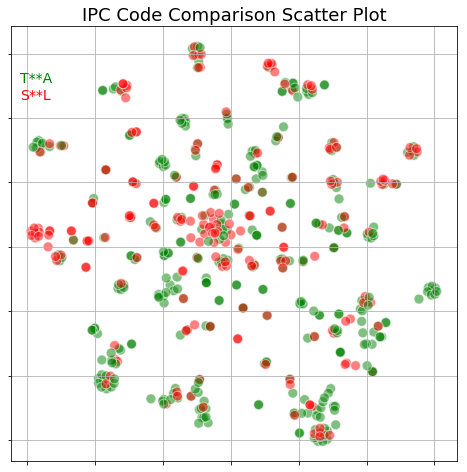

In [16]:
color1 = 'green'
color2 = 'red'
tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
colors = np.where(df5['company'] == 'TATA', color1, color2)
#ax = tsne_df.plot.scatter(x='x', y='y', figsize=(12, 6), grid=True, alpha=0.5, color=colors, edgecolors='white', s=96)
ax = tsne_df.plot.scatter(x='x', y='y', figsize=(8, 8), grid=True, alpha=0.5, color=colors, edgecolors='white', s=96)
ax.set_xlabel('')
ax.set_ylabel('')
ax.text(-31, 25.5, 'T**A', color=color1, fontsize=14)
ax.text(-31, 23, 'S**L', color=color2, fontsize=14)
ax.set_title('IPC Code Comparison Scatter Plot', fontsize=18)
ax.set_xticklabels(['' for i in range(6)])
ax.set_yticklabels(['' for i in range(7)])
plt.savefig('ipc-scatter.png')
None